In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import module extracted from processing phase
from functions_collection import LeagueInfo, MatchShow, ResultShow, Performance, HeadToHead

In [3]:
path = '/content/drive/My Drive/MyFolder/cleaned_divisions.csv'
divisions = pd.read_csv(path)

path = '/content/drive/My Drive/MyFolder/cleaned_matches.csv'
matches = pd.read_csv(path)

path = '/content/drive/My Drive/MyFolder/cleaned_relation.csv'
div_season_match_team = pd.read_csv(path)

path = '/content/drive/My Drive/MyFolder/all_results.csv'
all_results = pd.read_csv(path)

In [ ]:
# verify the data
divisions

,division,name,country
0,D1,Bundesliga,Deutschland
1,E0,Premier League,England
2,F1,Ligue 1,France
3,I1,Seria A,Italy
4,N1,Eredivisie,Netherlands
5,SP1,LaLiga,Spain


In [4]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season
0,D1,2020-09-18,Bayern Munich,Schalke 04,8.0,0.0,H,2021
1,D1,2020-09-19,Ein Frankfurt,Bielefeld,1.0,1.0,D,2021
2,D1,2020-09-19,FC Koln,Hoffenheim,2.0,3.0,A,2021
3,D1,2020-09-19,Stuttgart,Freiburg,2.0,3.0,A,2021
4,D1,2020-09-19,Union Berlin,Augsburg,1.0,3.0,A,2021


In [5]:
div_season_match_team.set_index(['Div', 'season'], inplace=True)
div_season_match_team

No of Matches  No of Teams
Div season                            
D1  2006              306         18.0
    2007              306         18.0
    2008              306         18.0
    2009              306         18.0
    2010              306         18.0
...                   ...          ...
SP1 2017              380         20.0
    2018              380         20.0
    2019              380         20.0
    2020              380         20.0
    2021              380         20.0

[96 rows x 2 columns]

In [6]:
all_results.head()

,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points,Rank,Round,Season,Div
0,Werder Bremen,1,1.0,0.0,0.0,5.0,2.0,3.0,3.0,1,1,2006,D1
1,Leverkusen,1,1.0,0.0,0.0,4.0,1.0,3.0,3.0,2,1,2006,D1
2,Hamburg,1,1.0,0.0,0.0,3.0,0.0,3.0,3.0,3,1,2006,D1
3,Bayern Munich,1,1.0,0.0,0.0,3.0,0.0,3.0,3.0,4,1,2006,D1
4,Schalke 04,1,1.0,0.0,0.0,2.0,1.0,1.0,3.0,5,1,2006,D1


In [7]:
# initialize objects
info = LeagueInfo()
mshow = MatchShow()
rshow = ResultShow()
per = Performance()
h2h = HeadToHead()

# Analyze the original dataset

Winrate of home team

In [ ]:
# no filter
matches['FTR'].value_counts(normalize=True) * 100

H    45.941008
A    28.744438
D    25.314553
Name: FTR, dtype: float64

In [ ]:
# filter by leagues
matches.groupby('Div')['FTR'].value_counts(normalize=True).unstack(level=-1) * 100

FTR,A,D,H
Div,,,
D1,30.085784,25.102124,44.812092
E0,29.539474,24.457237,46.003289
F1,27.228634,28.014718,44.756648
I1,28.305921,26.200658,45.493421
N1,29.261717,23.102447,47.635836
SP1,28.388158,24.555921,47.055921


In [ ]:
# filter by seasons
matches.groupby('season')['FTR'].value_counts(normalize=True).unstack(level=-1) * 100

FTR,A,D,H
season,,,
2006,27.485929,26.454034,46.060038
2007,26.266417,27.016886,46.716698
2008,27.298311,26.407129,46.294559
2009,27.532833,25.187617,47.279550
2010,26.454034,25.234522,48.311445
2011,26.641651,25.844278,47.514071
2012,27.157598,25.703565,47.138837
2013,28.658537,25.891182,45.450281
2014,29.362101,23.921201,46.716698


# The final position and other stats

In [10]:
def new_league_result_season(division, season):
    maxround = info.max_round(div_season_match_team, division, season)
    filter = (all_results['Div']==division) & (all_results['Season']==season) & (all_results['Round']==maxround)
    frame = all_results[filter]
    return frame

## The relation between goal scores and final position

Begin with a toy subset

In [ ]:
test = all_results[all_results['Div']=='E0']
test = test[test[['Season', 'Round']]==[2021, 38]].reset_index(drop=True)
test

In [11]:
# setting parameters
seasons = range(2006, 2022)
d = 'SP1'
ranks = [1, 2]
data = []

for rank in ranks:
    for season in seasons:
        # get final results
        query = new_league_result_season(d, season)
        query = query[['GF', 'GA', 'GD', 'Rank']]
        # assigning
        GF_rank = query.sort_values(by=['GF'], ascending=False).iloc[rank-1]['Rank']
        GA_rank = query.sort_values(by=['GA'], ascending=True).iloc[rank-1]['Rank']
        GD_rank = query.sort_values(by=['GD'], ascending=False).iloc[rank-1]['Rank']
        # create a new row
        new_row = (rank, season, GF_rank, GA_rank, GD_rank)
        data.append(new_row)
df = pd.DataFrame(data, columns=['Rank', 'Season', 'GF', 'GA', 'GD'])
df

,Rank,Season,GF,GA,GD
0,1,2006,1.0,6.0,1.0
1,1,2007,1.0,1.0,1.0
2,1,2008,1.0,1.0,1.0
3,1,2009,1.0,1.0,1.0
4,1,2010,2.0,1.0,1.0
5,1,2011,2.0,1.0,1.0
6,1,2012,1.0,2.0,1.0
7,1,2013,1.0,3.0,1.0
8,1,2014,3.0,1.0,2.0
9,1,2015,2.0,1.0,1.0


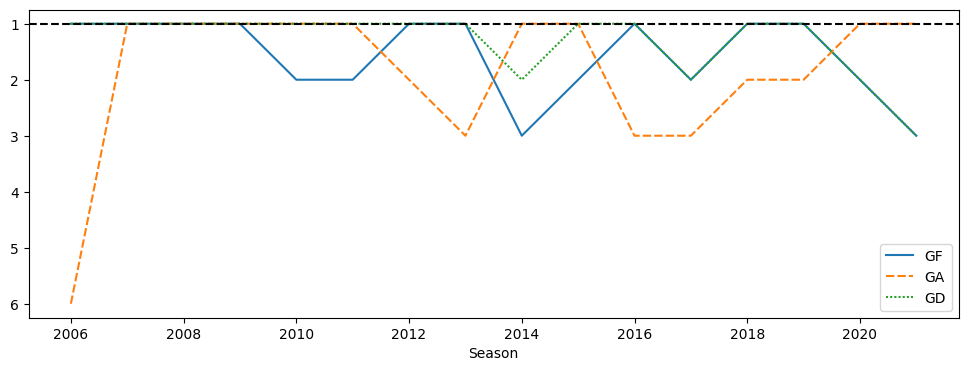

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
new_df = df.query('Rank == 1')
new_df = new_df[['Season', 'GF', 'GA', 'GD']].set_index('Season')
ax = sns.lineplot(new_df)
ax.axhline(y=1, c='k', ls='--')
ax.invert_yaxis()
plt.show() # Rank and GD are almost concident

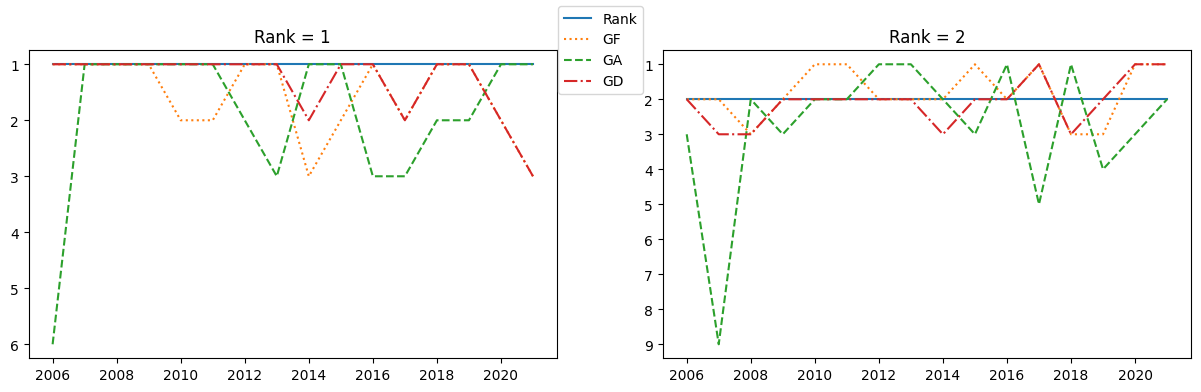

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i, ax in enumerate(axes):
    n_new_df = df[df['Rank']==i+1]
    ax.plot(n_new_df['Season'], n_new_df[['Rank']], label='Rank')
    ax.plot(n_new_df['Season'], n_new_df[['GF']], ls=':', label='GF')
    ax.plot(n_new_df['Season'], n_new_df[['GA']], ls='--', label='GA')
    ax.plot(n_new_df['Season'], n_new_df[['GD']], ls='-.', label='GD')
    ax.set_title(f'Rank = {i+1}')
    ax.invert_yaxis()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

Generalize to functions

In [12]:
# calculate goals ranking
def rank_by_goals_cal(division, season):
    total_rank = div_season_match_team.loc[division].loc[season]['No of Teams']
    # first column
    Ranks = pd.Series(range(1, int(total_rank)+1), name='Rank')
    # get final result
    query = new_league_result_season(division, season)
    query = query[['GF', 'GA', 'GD', 'Rank']]
    # assigning
    GF_rank = query.sort_values(by=['GF'], ascending=False)['Rank'].rename('GF_rank')
    GF_rank = GF_rank.reset_index(drop=True)
    GA_rank = query.sort_values(by=['GA'], ascending=True)['Rank'].rename('GA_rank')
    GA_rank = GA_rank.reset_index(drop=True)
    GD_rank = query.sort_values(by=['GD'], ascending=False)['Rank'].rename('GD_rank')
    GD_rank = GD_rank.reset_index(drop=True)
    # create target frame
    df = pd.concat([Ranks, GF_rank, GA_rank, GD_rank], axis=1)
    return df

# format the result
def rank_by_goals_show(division, season):
    df = rank_by_goals_cal(division, season)
    df.set_index('Rank', drop=True, inplace=True)
    return df

In [13]:
# apply the above function for multiple seasons
def rank_by_goals_seasons(division, seasons=list(range(2006, 2022))):
    # initial frame
    df = rank_by_goals_cal(division, seasons[0])
    df['Season'] = seasons[0]
    for season in seasons[1:]:
        new_df = rank_by_goals_cal(division, season)
        new_df['Season'] = season
        df = pd.concat([df, new_df])
    df.set_index('Season', drop=True, inplace=True)
    return df

In [ ]:
# test
# rank_by_goals_show('D1', 2021)
rank_by_goals_seasons('SP1', seasons=[2020, 2021])

,Rank,GF_rank,GA_rank,GD_rank
Season,,,,
2020,1,2,1,2
2020,2,1,3,1
2020,3,5,4,3
2020,4,6,8,4
2020,5,4,2,5
2020,6,7,11,6
2020,7,3,13,7
2020,8,15,7,8
2020,9,12,6,11


Aggregate by averages

In [14]:
def avg_rank_by_goals(division):
    frame = rank_by_goals_seasons(division)
    frame['GF_rank'] -= frame['Rank']
    frame['GA_rank'] -= frame['Rank']
    frame['GD_rank'] -= frame['Rank']
    stats_table = frame.groupby('Rank').mean()
    return stats_table

In [15]:
def avg_rank_by_goals_plot(division):
    full_name = divisions.query('division == @division').iloc[0]['name']
    stats_table = avg_rank_by_goals(division)
    ax = stats_table.plot()
    ax.axhline(y=0, ls='--')
    ax.set_xticks(stats_table.index)
    ax.set_title(f"{full_name}'s Deviation Goals Ranking over all seasons")
    plt.show()

In [ ]:
set(matches['Div'])

{'D1', 'E0', 'F1', 'I1', 'N1', 'SP1'}

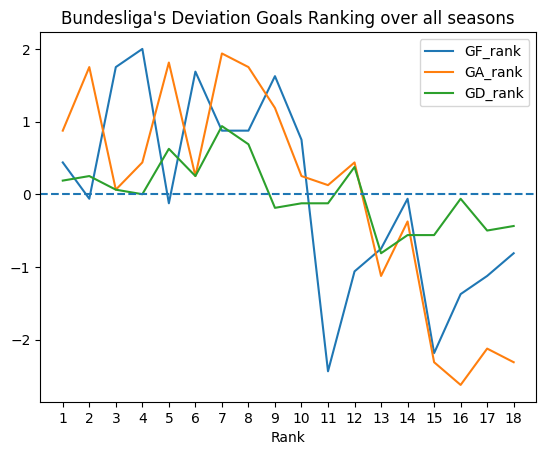

In [ ]:
# plotting for each league
avg_rank_by_goals_plot('D1')
# avg_rank_by_goals_plot('E0')
# avg_rank_by_goals_plot('F1')
# avg_rank_by_goals_plot('I1')
# avg_rank_by_goals_plot('N1')
# avg_rank_by_goals_plot('SP1')

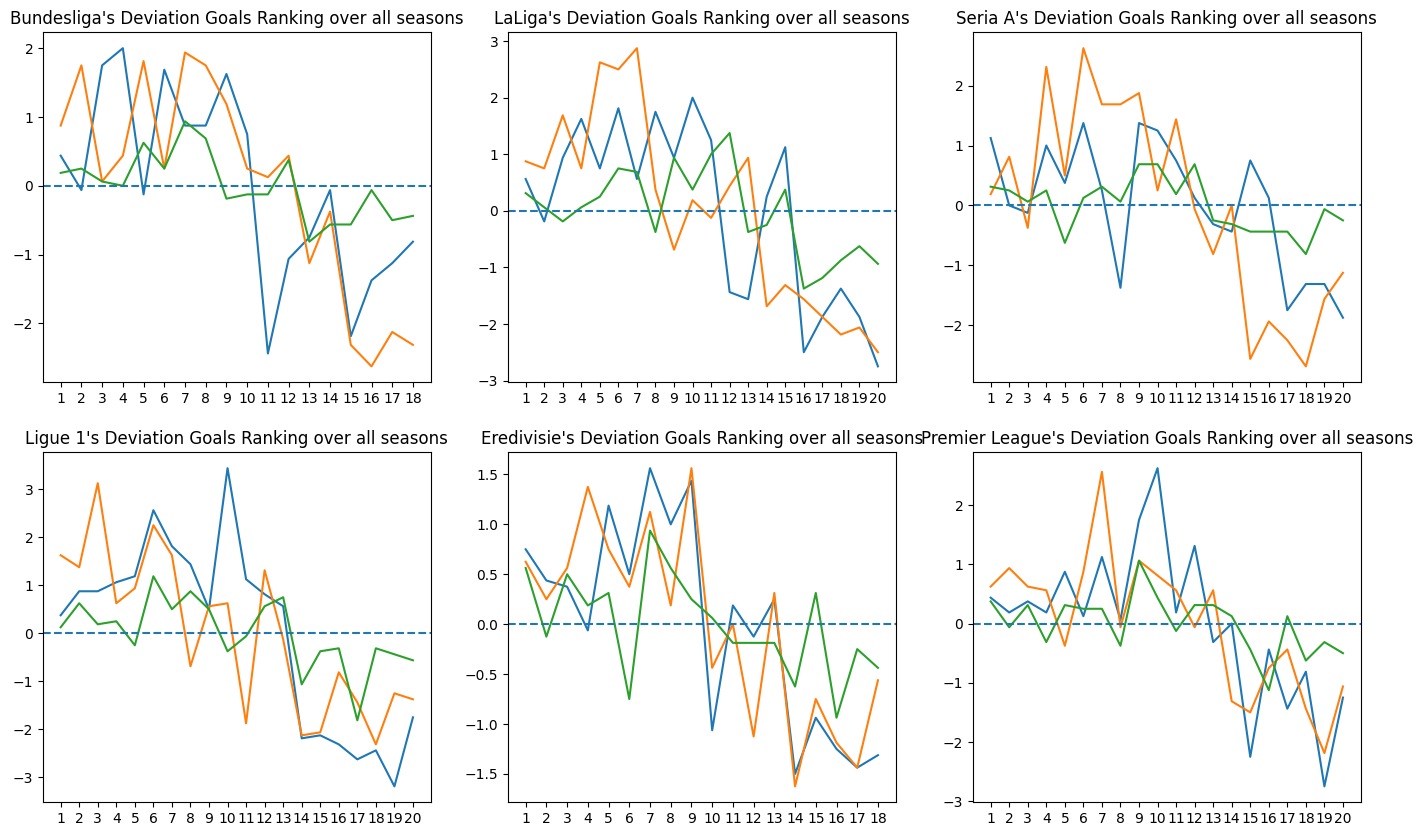

In [16]:
# plotting for all leagues
leagues = list(set(matches['Div']))

fig, axes = plt.subplots(2, 3, figsize=(17, 10))

for i, league in enumerate(leagues):
    # calculate the coordinate
    row = int(i / 3)
    col = (i % 3) - 1
    full_name = divisions.query('division == @league').iloc[0]['name']
    stats_table = avg_rank_by_goals(league)
    axes[row, col].plot(stats_table['GF_rank'])
    axes[row, col].plot(stats_table['GA_rank'])
    axes[row, col].plot(stats_table['GD_rank'])
    axes[row, col].axhline(y=0, ls='--')
    axes[row, col].set_xticks(stats_table.index)
    axes[row, col].set_title(f"{full_name}'s Deviation Goals Ranking over all seasons")

plt.show()

In [17]:
# verify the observation
df1 = avg_rank_by_goals('D1').apply(np.abs).mean()
df2 = avg_rank_by_goals('E0').apply(np.abs).mean()
df3 = avg_rank_by_goals('F1').apply(np.abs).mean()
df4 = avg_rank_by_goals('I1').apply(np.abs).mean()
df5 = avg_rank_by_goals('N1').apply(np.abs).mean()
df6 = avg_rank_by_goals('SP1').apply(np.abs).mean()

rename_dict = {0: 'D1', 1: 'E0', 2: 'F1', 3: 'I1', 4: 'N1', 5: 'SP1'}
pd.concat([df1, df2, df3, df4, df5, df6], axis=1).rename(columns=rename_dict)

,D1,E0,F1,I1,N1,SP1
GF_rank,1.111111,0.92500,1.66250,0.8500,0.854167,1.35625
GA_rank,1.208333,0.91875,1.40625,1.3375,0.791667,1.40000
GD_rank,0.375000,0.38750,0.55625,0.3625,0.409722,0.61875


## The performance of top teams of the very last season

In [ ]:
# show the final positions of top teams of the last season
def pre_cur_rank(division, n_rank=4):
    seasons = range(2006, 2022)
    Ranks = pd.Series(range(1, int(n_rank)+1), name='Rank')
    for i in range(1, 15):
        prev_result = rshow.league_result_season(matches, div_season_match_team, division, seasons[i-1]).iloc[:4]['Rank']
        top_teams = prev_result.index
        # if a top team is relegated to lower league, use the ranks of the last season
        try:
            x = rshow.league_result_season(matches, div_season_match_team, division, seasons[i]).loc[top_teams]
        except KeyError:
            curr_result = prev_result.copy(deep=True)
        else:
            curr_result = rshow.league_result_season(matches, div_season_match_team, division, seasons[i]).loc[top_teams]['Rank']
        curr_result.reset_index(drop=True, inplace=True)
        curr_result.rename(f'{seasons[i]}', inplace=True)
        Ranks = pd.concat([Ranks, curr_result], axis=1)
    return Ranks

# format the result for better plotting
def pre_cur_rank_plot(division, n_rank=4):
    full_name = divisions.query('division == @division').iloc[0]['name']
    Ranks = pre_cur_rank(division, n_rank)
    Ranks.set_index('Rank', inplace=True)
    ax = Ranks.T.plot()
    ax.set_title(f"Rank's Changing after one season in {full_name}")
    plt.show()

In [34]:
# show the final positions of top teams of the last season
def pre_cur_rank(division, n_rank=4, seasons = range(2006, 2022)):
    Ranks = pd.Series(range(1, int(n_rank)+1), name='Rank')
    # build the result of all seasons
    result_list = []
    for season in seasons:
        result_list.append(new_league_result_season(division, season))
    result_frame = pd.concat(result_list).reset_index(drop=True)
    # another loop for doing function
    for season in seasons[1:]:
        # the previous season
        prev_top_result = result_frame[result_frame['Season']==season-1].iloc[:4]
        top_teams = prev_top_result['Team']
        # the current season
        curr_result = result_frame[result_frame['Season']==season]
        curr_result.set_index('Team', drop=True, inplace=True)
        # if a top team is relegated to lower league, use the ranks of the last season
        try:
            x = curr_result.loc[top_teams]
        except KeyError:
            curr_top_result = pd.Series([1, 2, 3, 4])
        else:
            curr_top_result = curr_result.loc[top_teams]['Rank']
        curr_top_result.reset_index(drop=True, inplace=True)
        curr_top_result.rename(f'{season}', inplace=True)
        Ranks = pd.concat([Ranks, curr_top_result], axis=1)
    return Ranks

In [43]:
# format the result for better plotting
def pre_cur_rank_plot(division, n_rank=4):
    full_name = divisions.query('division == @division').iloc[0]['name']
    Ranks = pre_cur_rank(division, n_rank)
    Ranks.set_index('Rank', inplace=True)
    ax = Ranks.T.plot()
    ax.set_title(f"Rank's Changing after one season in {full_name}")
    ax.set_yticks(range(1, 21))
    plt.show()

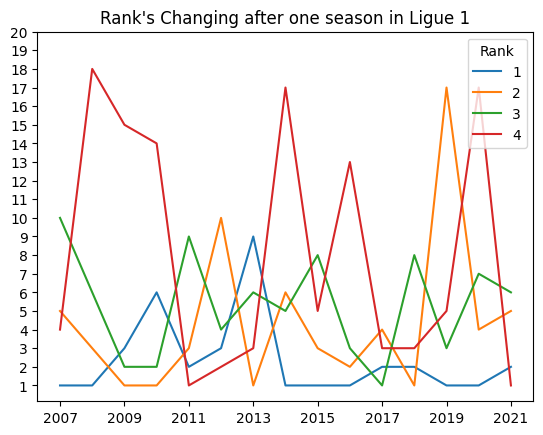

In [44]:
# test
# pre_cur_rank_plot('D1')
# pre_cur_rank_plot('E0')
pre_cur_rank_plot('F1')
# pre_cur_rank_plot('I1')
# pre_cur_rank_plot('N1')
# pre_cur_rank_plot('SP1')

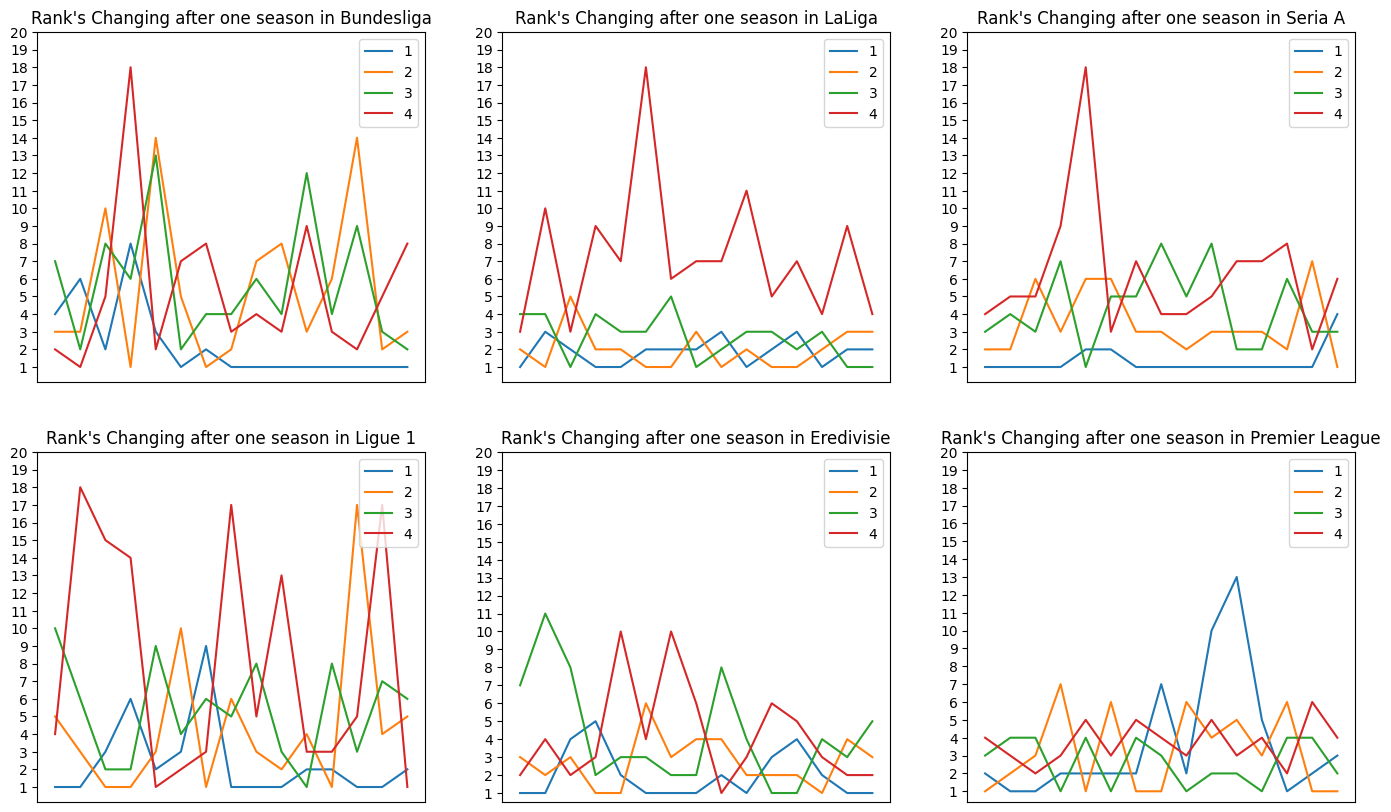

In [49]:
leagues = list(set(matches['Div']))
n_rank = 4

fig, axes = plt.subplots(2, 3, figsize=(17, 10))
for i, league in enumerate(leagues):
    # calculate the coordinate
    row = int(i / 3)
    col = (i % 3) - 1
    full_name = divisions.query('division == @league').iloc[0]['name']
    Ranks = pre_cur_rank(league, n_rank)
    Ranks.set_index('Rank', inplace=True)
    Ranks = Ranks.T
    for column in Ranks.columns:
        axes[row, col].plot(Ranks[column], label=f'{column}')
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks(range(1, 21))
        axes[row, col].legend(loc='upper right')
    axes[row, col].set_title(f"Rank's Changing after one season in {full_name}")

plt.show()

In [46]:
# verify the observation
df1 = pre_cur_rank('D1').mean(axis=1)
df2 = pre_cur_rank('E0').mean(axis=1)
df3 = pre_cur_rank('F1').mean(axis=1)
df4 = pre_cur_rank('I1').mean(axis=1)
df5 = pre_cur_rank('N1').mean(axis=1)
df6 = pre_cur_rank('SP1').mean(axis=1)

rename_dict = {0: 'D1', 1: 'E0', 2: 'F1', 3: 'I1', 4: 'N1', 5: 'SP1'}
pd.concat([df1, df2, df3, df4, df5, df6], axis=1).rename(columns=rename_dict)

,D1,E0,F1,I1,N1,SP1
0,2.1875,3.5000,2.3125,1.3125,1.9375,1.8125
1,5.2500,3.1250,4.2500,3.3750,2.6875,2.0000
2,5.5625,2.6875,5.1875,4.2500,4.1875,2.6875
3,5.2500,3.7500,7.8125,6.1250,4.1875,7.1250


# Examine the measures

## Measures

### Changing of upper table

In [58]:
# change of upper tables in given season
def upper_change(division, season, n_ranks=4):
    maxround = info.max_round(div_season_match_team, division, season)
    change_num = []
    # filter by context
    filter = (all_results['Div']==division) & (all_results['Season']==season) & (all_results['Rank']<=n_ranks)
    upper_table = all_results[filter]
    for round in range(2, maxround+1):
        old_upper_teams = upper_table[upper_table['Round']==(round-1)]['Team']
        old_upper_teams = set(old_upper_teams)
        upper_teams = upper_table[upper_table['Round']==round]['Team']
        upper_teams = set(upper_teams)
        change = len(upper_teams.difference(old_upper_teams))
        change_num.append(change)
    return change_num

In [59]:
# change of upper tables in given set of seasons
def upper_change_seasons(division, seasons=range(2006, 2022), n_ranks=4):
    change_dict = {}
    for season in seasons:
        change_dict[season] = np.array(upper_change(division, season, n_ranks)).mean()
    return change_dict

In [60]:
def weighted_average(list, weighted_list=[3, 5]):
    tail = len(list) - (5 * len(weighted_list))
    list = np.array(list)
    list[tail:(tail+5)] *= weighted_list[0]
    list[(tail+5):] *= weighted_list[1]
    weighted_mean = list.mean()
    return weighted_mean

In [81]:
# weighted version
def weighted_upper_change_seasons(division, seasons=range(2006, 2022), n_ranks=4):
    # store in a dictionary
    change_dict = {}
    for season in seasons:
        change_dict[season] = weighted_average(upper_change(division, season, n_ranks))
    return change_dict

Apply for top 4

In [65]:
D1_weighted = weighted_upper_change_seasons('D1')
E0_weighted = weighted_upper_change_seasons('E0')
F1_weighted = weighted_upper_change_seasons('F1')
I1_weighted = weighted_upper_change_seasons('I1')
N1_weighted = weighted_upper_change_seasons('N1')
SP1_weighted = weighted_upper_change_seasons('SP1')

In [67]:
D1_col = pd.Series(D1_weighted.values(), index=D1_weighted.keys(), name='D1')
E0_col = pd.Series(E0_weighted.values(), index=E0_weighted.keys(), name='E0')
F1_col = pd.Series(F1_weighted.values(), index=F1_weighted.keys(), name='F1')
I1_col = pd.Series(I1_weighted.values(), index=I1_weighted.keys(), name='I1')
N1_col = pd.Series(N1_weighted.values(), index=N1_weighted.keys(), name='N1')
SP1_col = pd.Series(SP1_weighted.values(), index=SP1_weighted.keys(), name='SP1')

top_4_variation = pd.concat([D1_col, E0_col, F1_col, I1_col, N1_col, SP1_col], axis=1)
top_4_variation

,D1,E0,F1,I1,N1,SP1
2006,0.090909,0.486486,0.972973,0.594595,0.696970,0.648649
2007,0.363636,0.540541,1.108108,0.648649,0.272727,0.621622
2008,1.484848,0.648649,0.540541,0.594595,1.242424,0.567568
2009,0.727273,0.540541,1.189189,0.702703,0.666667,0.513514
2010,0.666667,0.621622,1.054054,0.540541,0.454545,0.540541
2011,0.696970,0.243243,0.837838,0.783784,0.787879,0.216216
2012,0.545455,0.459459,0.783784,0.810811,0.909091,0.432432
2013,0.575758,0.594595,1.081081,0.351351,0.363636,0.729730
2014,0.484848,0.405405,0.243243,0.216216,0.939394,0.108108
2015,0.757576,0.324324,0.675676,0.864865,0.666667,0.351351


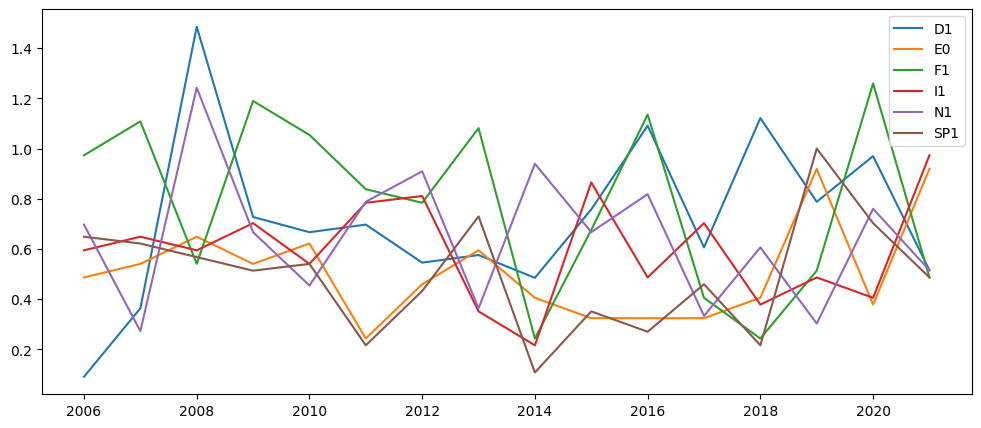

In [73]:
ax = top_4_variation.plot(figsize=(12, 5))
plt.show()

Apply for champion's position

In [84]:
D1_weighted = weighted_upper_change_seasons('D1', n_ranks=1)
E0_weighted = weighted_upper_change_seasons('E0', n_ranks=1)
F1_weighted = weighted_upper_change_seasons('F1', n_ranks=1)
I1_weighted = weighted_upper_change_seasons('I1', n_ranks=1)
N1_weighted = weighted_upper_change_seasons('N1', n_ranks=1)
SP1_weighted = weighted_upper_change_seasons('SP1', n_ranks=1)

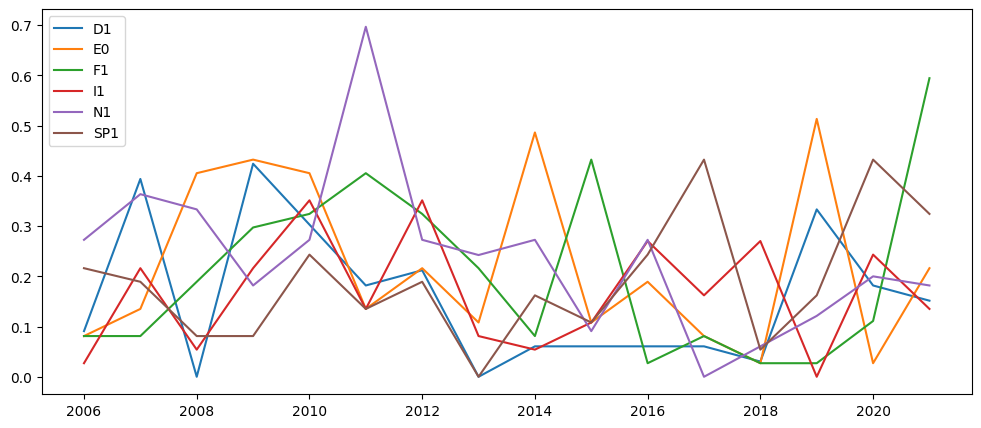

In [85]:
D1_col = pd.Series(D1_weighted.values(), index=D1_weighted.keys(), name='D1')
E0_col = pd.Series(E0_weighted.values(), index=E0_weighted.keys(), name='E0')
F1_col = pd.Series(F1_weighted.values(), index=F1_weighted.keys(), name='F1')
I1_col = pd.Series(I1_weighted.values(), index=I1_weighted.keys(), name='I1')
N1_col = pd.Series(N1_weighted.values(), index=N1_weighted.keys(), name='N1')
SP1_col = pd.Series(SP1_weighted.values(), index=SP1_weighted.keys(), name='SP1')

top_1_variation = pd.concat([D1_col, E0_col, F1_col, I1_col, N1_col, SP1_col], axis=1)
ax = top_1_variation.plot(figsize=(12, 5))
plt.show()

In [86]:
top_4_variation.mean()

D1     0.717803
E0     0.508446
F1     0.783096
I1     0.596284
N1     0.645985
SP1    0.491554
dtype: float64

In [87]:
top_1_variation.mean()

D1     0.159091
E0     0.222973
F1     0.206269
I1     0.167230
N1     0.239773
SP1    0.190878
dtype: float64

### Seasonal races

In [117]:
# retrieve conditional table
def result_filter_by_loc(division, season, round, n_ranks=5, loc='upper'):
    # apply the filter for context
    filter = (all_results['Div']==division) & (all_results['Season']==season) & (all_results['Round']==round)
    try:
        all_results[filter]
    except KeyError:
        return 'Choose Another Round!'
    else:
        target_table = all_results[filter]
    # access 'loc' parameter
    if loc == 'all':
        values = target_table['Points'].to_numpy()
    elif loc == 'upper':
        values = target_table.iloc[:n_ranks]['Points'].to_numpy()
    elif loc == 'lower':
        values = target_table.iloc[-n_ranks:]['Points'].to_numpy()
    else:
        return "Choose Another 'loc' Value!"
    return values

In [103]:
# define measure
def diff_point(array):
    diff_list = array[1:] - array[:-1]
    score = np.sqrt(np.mean(diff_list ** 2))
    return score

In [104]:
# total DP score at a timepoint
def total_diff_point(division, season, round):
    point_list = result_filter_by_loc(division, season, round, 0, loc='all')
    if isinstance(point_list, str):
        return point_list
    else:
        dp_score = diff_point(point_list)
        return dp_score

In [105]:
# locally DP score at a timepoint
def local_diff_point(division, season, round, n_ranks=5, loc='upper'):
    point_list = result_filter_by_loc(division, season, round, n_ranks, loc)
    if isinstance(point_list, str):
        return point_list
    else:
        dp_score = diff_point(point_list)
        return dp_score

In [128]:
# weighted average of total DP score of a season
def avg_diff_point(division, season):
    maxround = info.max_round(div_season_match_team, division, season)
    dp_score_list = [] # store dp scores of all rounds
    for round in range(1, maxround+1):
        dp_elem = total_diff_point(division, season, round)
        dp_score_list.append(dp_elem)
    # reuse weighted_average function
    weighted_dp_score = weighted_average(dp_score_list, weighted_list=[0.5, 0.2])
    return weighted_dp_score

In [109]:
# weighted average of locally DP score of a season
def avg_local_diff_point(division, season, n_ranks=5, loc='upper'):
    maxround = info.max_round(div_season_match_team, division, season)
    dp_score_list = []
    for round in range(1, maxround+1):
        dp_elem = local_diff_point(division, season, round, n_ranks, loc)
        # check 'loc' value
        if isinstance(dp_elem, str):
            return dp_elem
        else:
            dp_score_list.append(dp_elem)
    weighted_dp_score = weighted_average(dp_score_list, weighted_list=[0.5, 0.2])
    return weighted_dp_score

In [137]:
# weighted average of total DP score of given seasons
def avg_diff_point_seasons(division, seasons=range(2006, 2022)):
    # store in a dictionary
    dp_dict = {}
    for season in seasons:
        dp_dict[season] = avg_diff_point(division, season)
    return dp_dict

In [136]:
# weighted average of locally DP score of given seasons
def avg_local_diff_point_seasons(division, seasons=range(2006, 2022), n_ranks=5, loc='upper'):
    dp_dict = {}
    for season in seasons:
        new_score = avg_local_diff_point(division, season, n_ranks, loc)
        if isinstance(new_score, str):
            continue
        else:
            dp_dict[season] = new_score
    return dp_dict

In [138]:
# get all data
D1_total_dp = avg_diff_point_seasons('D1')
E0_total_dp = avg_diff_point_seasons('E0')
F1_total_dp = avg_diff_point_seasons('F1')
I1_total_dp = avg_diff_point_seasons('I1')
N1_total_dp = avg_diff_point_seasons('N1')
SP1_total_dp = avg_diff_point_seasons('SP1')

In [139]:
D1_col = pd.Series(D1_total_dp.values(), index=D1_total_dp.keys(), name='D1')
E0_col = pd.Series(E0_total_dp.values(), index=E0_total_dp.keys(), name='E0')
F1_col = pd.Series(F1_total_dp.values(), index=F1_total_dp.keys(), name='F1')
I1_col = pd.Series(I1_total_dp.values(), index=I1_total_dp.keys(), name='I1')
N1_col = pd.Series(N1_total_dp.values(), index=N1_total_dp.keys(), name='N1')
SP1_col = pd.Series(SP1_total_dp.values(), index=SP1_total_dp.keys(), name='SP1')

total_dp = pd.concat([D1_col, E0_col, F1_col, I1_col, N1_col, SP1_col], axis=1)
total_dp

,D1,E0,F1,I1,N1,SP1
2006,1.945844,2.685264,2.085829,2.226633,2.337157,1.681333
2007,1.313331,2.038758,2.264038,2.352884,1.965447,1.543392
2008,1.490289,2.067931,2.002616,1.778579,1.631678,2.006432
2009,1.334350,1.635367,1.601222,1.682381,1.731939,2.066617
2010,1.579030,1.840013,1.910904,1.739811,2.143992,2.308519
2011,1.905978,1.452540,2.068804,1.577322,1.843483,2.181718
2012,1.540829,1.983686,1.506987,1.646185,1.708331,2.386639
2013,2.480542,1.985673,1.497831,1.687498,1.689790,2.320060
2014,2.466952,1.679445,1.926601,2.206814,1.285342,2.339920
2015,1.888713,1.760569,1.448442,2.118268,2.067890,1.882064


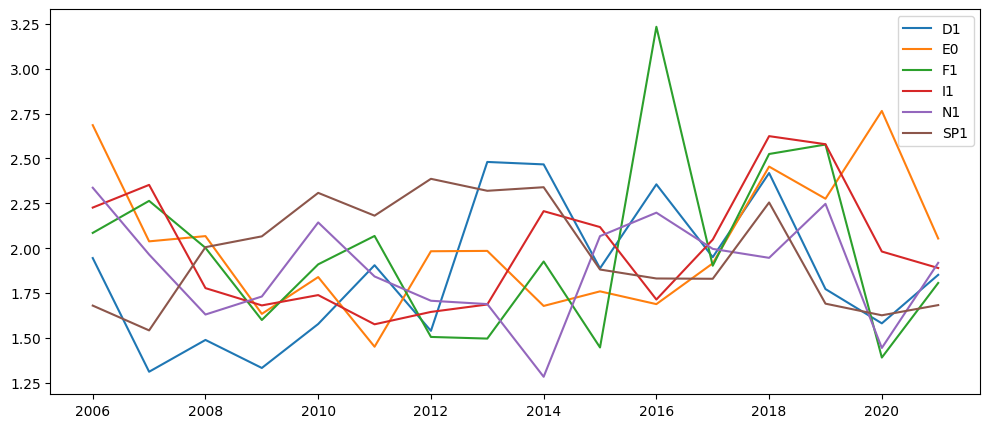

In [140]:
ax = total_dp.plot(figsize=(12, 5))
plt.show()

In [147]:
# get top 5 ranks only
D1_local_dp = avg_local_diff_point_seasons('D1', loc='upper')
E0_local_dp = avg_local_diff_point_seasons('E0', loc='upper')
F1_local_dp = avg_local_diff_point_seasons('F1', loc='upper')
I1_local_dp = avg_local_diff_point_seasons('I1', loc='upper')
N1_local_dp = avg_local_diff_point_seasons('N1', loc='upper')
SP1_local_dp = avg_local_diff_point_seasons('SP1', loc='upper')

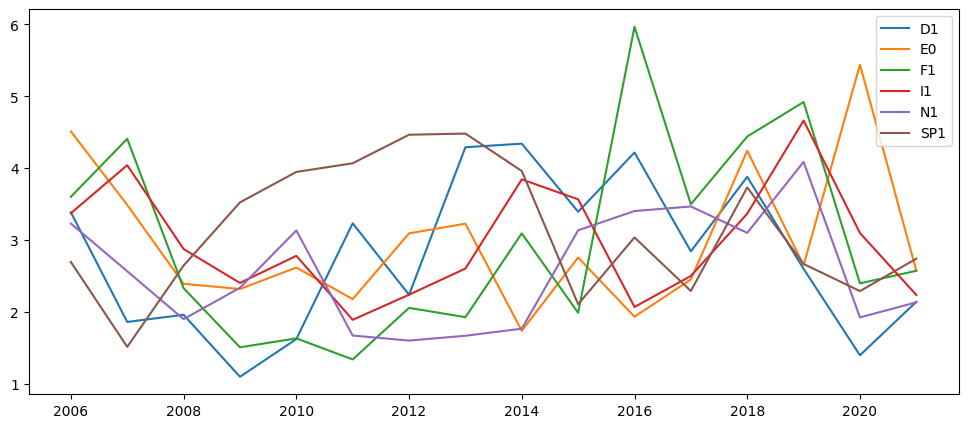

In [148]:
D1_col = pd.Series(D1_local_dp.values(), index=D1_local_dp.keys(), name='D1')
E0_col = pd.Series(E0_local_dp.values(), index=E0_local_dp.keys(), name='E0')
F1_col = pd.Series(F1_local_dp.values(), index=F1_local_dp.keys(), name='F1')
I1_col = pd.Series(I1_local_dp.values(), index=I1_local_dp.keys(), name='I1')
N1_col = pd.Series(N1_local_dp.values(), index=N1_local_dp.keys(), name='N1')
SP1_col = pd.Series(SP1_local_dp.values(), index=SP1_local_dp.keys(), name='SP1')

top_local_dp = pd.concat([D1_col, E0_col, F1_col, I1_col, N1_col, SP1_col], axis=1)
ax = top_local_dp.plot(figsize=(12, 5))
plt.show()

In [149]:
# get bottom 5 ranks only
D1_local_dp = avg_local_diff_point_seasons('D1', loc='lower')
E0_local_dp = avg_local_diff_point_seasons('E0', loc='lower')
F1_local_dp = avg_local_diff_point_seasons('F1', loc='lower')
I1_local_dp = avg_local_diff_point_seasons('I1', loc='lower')
N1_local_dp = avg_local_diff_point_seasons('N1', loc='lower')
SP1_local_dp = avg_local_diff_point_seasons('SP1', loc='lower')

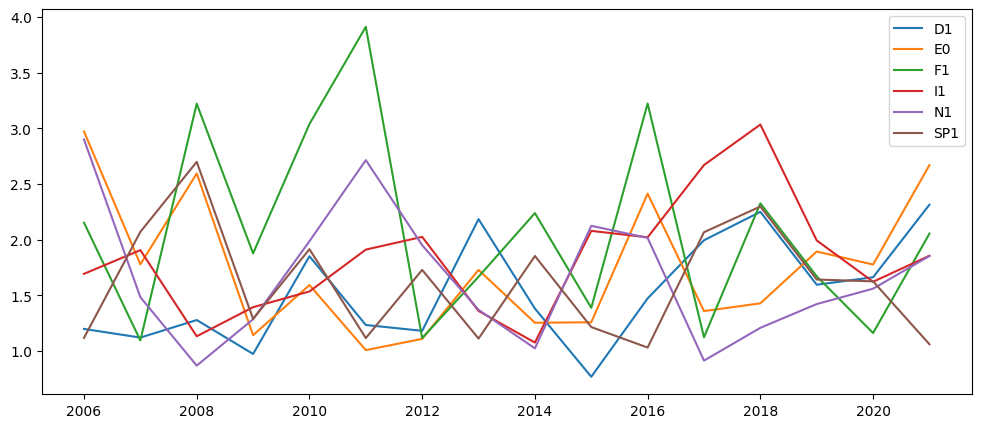

In [150]:
D1_col = pd.Series(D1_local_dp.values(), index=D1_local_dp.keys(), name='D1')
E0_col = pd.Series(E0_local_dp.values(), index=E0_local_dp.keys(), name='E0')
F1_col = pd.Series(F1_local_dp.values(), index=F1_local_dp.keys(), name='F1')
I1_col = pd.Series(I1_local_dp.values(), index=I1_local_dp.keys(), name='I1')
N1_col = pd.Series(N1_local_dp.values(), index=N1_local_dp.keys(), name='N1')
SP1_col = pd.Series(SP1_local_dp.values(), index=SP1_local_dp.keys(), name='SP1')

bot_local_dp = pd.concat([D1_col, E0_col, F1_col, I1_col, N1_col, SP1_col], axis=1)
ax = bot_local_dp.plot(figsize=(12, 5))
plt.show()

In [156]:
total = total_dp.mean()
top_local = top_local_dp.mean()
bot_local = bot_local_dp.mean()
df = pd.concat([total, top_local, bot_local], axis=1)
df.rename(columns={0: 'total', 1: 'top_local', 2: 'bot_local'}, inplace=True)
df

,total,top_local,bot_local
D1,1.867492,2.780491,1.529530
E0,2.017797,2.975066,1.749250
F1,1.984430,2.979220,2.079851
I1,1.990982,2.971093,1.832442
N1,1.884982,2.569425,1.668260
SP1,1.977387,3.134674,1.615693


In [157]:
df.loc[['E0', 'F1', 'I1', 'SP1']]

,total,top_local,bot_local
E0,2.017797,2.975066,1.749250
F1,1.984430,2.979220,2.079851
I1,1.990982,2.971093,1.832442
SP1,1.977387,3.134674,1.615693
